# Source-filter sound generative model 

## Impulse repsonses of the surface and the scraper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from numpy import random
import soundfile as sf
import random
import IPython
import librosa
from scipy import interpolate
import scipy
import scipy.integrate as integrate
import ipywidgets as widgets
from pylab import figure, cm
from scipy.optimize import minimize
from sklearn import preprocessing
from scipy.integrate import odeint
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from scipy.interpolate import RegularGridInterpolator
#IPython.display.Audio("my_audio_file.mp3")

#Impuse Responses
def h(t,a,b,w,alpha,beta):
    return np.sum((10**((a-b*t)/20)) * np.cos(w*t))
    

def HT(t,alpha,beta):
    return np.sum(10**((alpha-beta*t)/20))




In [2]:
a=np.array([3,4,5])
b=np.array([3,5,7])
w=np.array([8,9,10])
print(h(0.3 ,a ,b ,w , 0.1,0.1))


-3.5270669462012947


## Position and velocity of scraper

C:\Users\Etienne\anaconda3\lib\site-packages\numpy\ma\core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


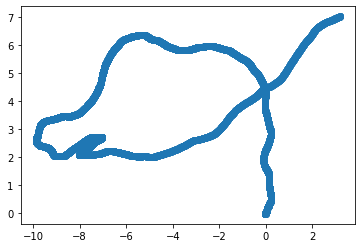

In [3]:
def random_traj_generator():
    positions=[]
    condition = True
    xfirst = 0
    yfirst = 0
    positions.append((xfirst,yfirst))
    previous_angle = np.random.uniform(-np.pi,np.pi,1)
    previous_distance = np.random.uniform(0,0.00005,1)
    i=0
    while condition==True:
        angle = np.random.normal(previous_angle,np.pi/100,1)
        distance = np.random.normal(previous_distance,0.0001,1)
        #print(distance)
        x = positions[i][0]+distance*np.cos(angle)
        y = positions[i][1]+distance*np.sin(angle)
        p=(x,y)
        positions.append(p)
        if np.sqrt((x-xfirst)**2 + (y - yfirst)**2)<1 and i>5000:
            positions.append([xfirst,yfirst])
            condition = False
        r= random.random()
        i+=1
        if i==10000 or r<0.0001:
            condition=False
        
        previous_angle = angle
        previous_distance = distance
    return positions


pos1 = random_traj_generator()
x=[]
y=[]
for p in pos1:
    x.append(p[0])
    y.append(p[1])
plt.scatter(x,y)
plt.show()


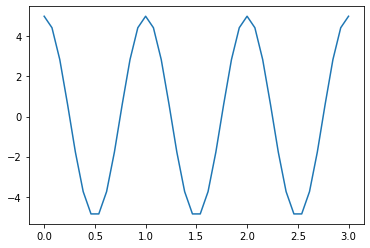

In [4]:
def circular_trajectory(r,T):
    def traj_x(t):
        return r*np.cos(t*(2*np.pi)/(3/T))
    def traj_y(t):
        return r*np.sin(t*(2*np.pi)/(3/T))
    def vx(t):
        return -r * (2*np.pi)/(3/T)  * np.sin((2*np.pi)/(3/T) *t)
    def vy(t):
        return -r*(2*np.pi)/(3/T) * np.cos((2*np.pi)/(3/T) *t)
    def ax(t):
        return -r*((2*np.pi)/(3/T))**2 * np.cos((2*np.pi)/(3/T) *t)
    def ay(t):
        return -r*((2*np.pi)/(3/T))**2 * np.sin((2*np.pi)/(3/T) *t)
    
    
    return traj_x,traj_y,vx,vy,ax,ay

fx,fy,vx,vy,ax,ay =  circular_trajectory(5,3)

t  = np.linspace(0,3,40)

plt.plot(t,fx(t))

In [5]:
def back_and_forth_trajectory(nbr_move,duration):
    move_duration = duration / nbr_move
    def traj_x(t):
        if (t // move_duration) % 2 == 0:
            return 0.07 * t % move_duration
        else:
            return -0.07 * t % move_duration
        
    def traj_y(t):
        if (t // move_duration)%2 == 0:
            return 0.03 * t % move_duration
        else:
            return -0.03 * t % move_duration
    def vx(t):
        if (t // move_duration) % 2 == 0:
            return 0.07 + t*0
        else:
            return -0.07 + t*0
    def vy(t):
        if (t // move_duration) % 2 == 0:
            return 0.03 + t*0
        else:
            return -0.03 + t*0
    def ax(t):
        return t*0
    def ay(t):
        return t*0
    return np.vectorize(traj_x),np.vectorize(traj_y),np.vectorize(vx),np.vectorize(vy),ax,ay



In [6]:

def compute_trajectory_from_positions(X,Y,max_nbr_pts,std_between_points,degree):
    f = interpolate.InterpolatedUnivariateSpline(X,Y,k=degree)


    pos=[[X[0],Y[0]],[X[0],Y[0]],[X[0],Y[0]],[X[0],Y[0]]]     #Initialize with a few statics points so the initial velocity is null


    pt = X[0]
    j=0
    last = X[len(X) - 1]
    distance=0
    while pt< last:
        distance =  np.abs(np.random.normal(distance,std_between_points))
        pos.append([pt,f(pt)])
        pt+=distance
        j+=1
    pos = np.array(pos)               
    plt.scatter(X,Y)
    print(np.shape(pos))        
    x=[]
    y=[]
    for p in pos:
        x.append(p[0])
        y.append(p[1])
    plt.plot(x,y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Interpolated trajectory of the scrapper on the 2d surface')
    plt.show()
    return pos


In [7]:
def trajectory_from_positions(positions,t):
    
    x=positions[:,0] / 10
    y=positions[:,1] / 10
 
    
    fx = interpolate.UnivariateSpline(t, x,s=1)
    fy = interpolate.UnivariateSpline(t, y,s=1)
    
        
    vx = fx.derivative(1)                        #Horizontal speed on x axis 
    vy = fy.derivative(1)                        #Horizontal speed on y axis 
 
    ax = fx.derivative(2)                        #Horizontal acceleration on x axis 
    ay = fy.derivative(2)                        #Horizontal acceleration on y axis
    
    #print('pos',x[0],y[0])
    #print('speed',vx(x[0]),vy(y[0]))
    #print(vx(pos[:10]))
    return fx,fy,vx,vy,ax,vy


In [8]:
def linear_traj(axis):
        def traj_x(t):
            if axis == 'x' or axis =='xy':
                return t/10 + np.random.normal(0,10**-3)
            
            else:
                return t*0
            
        def traj_y(t):
            if axis == 'y' or axis =='xy':
                return t/10 + np.random.normal(0,10**-3)
            else:
                return t*0
            
        def vx(t):
            if axis == 'x' or axis=='xy':
                return t*0 + 0.1  + np.random.normal(0,10**-3)
            else:
                return t*0
            
        def vy(t):
            if axis == 'y' or axis == 'xy':
                return t*0 + 0.1   +np.random.normal(0,10**-3)
            else:
                return t*0
            
        def ax(t):
            return t*0
        
        def ay(t):
            return t*0
        
        return np.vectorize(traj_x),np.vectorize(traj_y),np.vectorize(vx),np.vectorize(vy),ax,ay


In [9]:
def biological_traj():
    a=[1]
    wx = np.random.uniform(0,0.6,3)
    wy = np.random.uniform(0,0.6,3)
    a = np.concatenate((a,np.random.uniform(0.5,0.9,2)))     
    b=[1]
    b = np.concatenate((b,np.random.uniform(0.5,0.9,2)))
    A_0 = 7
    B_0 = 5
    def traj_x(t):
        t= t*5
        return A_0 *np.sum(a * np.sin(wx*t)) /20


    def traj_y(t):
        t= t*5
        return B_0 *np.sum(b * np.sin(wy*t)) /20
    
    def vx(t):
        t= t*5
        return A_0 *np.sum(a*wx*np.cos(wx*t))/20
    def vy(t):
        t= t*5
        return B_0 *np.sum(b*wy*np.cos(wy*t))/20
    
    def ax(t):
        t= t*5
        return A_0 *np.sum(-a  * wx**2 * np.sin(wx*t))/20
    def ay(t):
        t= t*5
        return B_0 * np.sum(-b  * wy**2 * np.sin(wy*t))/20
    
    return np.vectorize(traj_x),np.vectorize(traj_y),np.vectorize(vx),np.vectorize(vy),np.vectorize(ax),np.vectorize(ay)



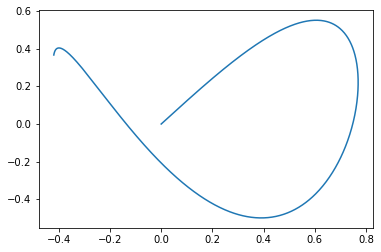

In [10]:
traj_x,traj_y,vx,vy,ax,ay = biological_traj()
ts = np.linspace(0,3,1000)
plt.plot(traj_x(ts),traj_y(ts))



## Surface depth and its partial derivatives

In [11]:
print(np.random.normal(0,0.1))

0.04272042523002184


(300, 300)


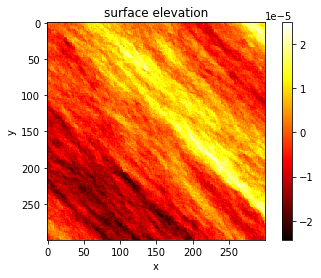

highest elevation: 2.493617928764325e-05


In [12]:
def create_surface(standard_elevation , mode):
    height = 0.003
    width = 0.003                   #The surface is 3 by 3 cm
    deltax = 0.00001     #Space between two measures is 0.01mm
    deltay = 0.00001
    x = np.linspace(0,width,int(width/deltax))
    y = np.linspace(0,height,int(height/deltay))
    constraint_factor = 10  #Factor constraining the surface from elevation beyond a certain height (determined by operation factor * std_elevation)
    
    s=0
    z=np.zeros((len(x),len(y)))
    if mode=="random_walk":
        for i in range(1,len(x)):
            z[i][0] = np.random.normal(z[i-1][0],standard_elevation)
        for j in range(1,len(y)):
            z[0][j] = np.random.normal(z[0][j-1],standard_elevation)
        for i in range(1,len(x)):
            for j in range(1,len(y)):
                coeff = np.random.uniform(0,1)
                z[i][j] = np.random.normal(coeff*z[i-1][j] + (1-coeff)*z[i][j-1] , standard_elevation)
    
    else:
        for i in range(np.shape(z)[0]):
            if mode == "stripes":
                a = np.random.normal(0,standard_elevation)
            for j in range(np.shape(z)[1]):
                if mode == "gradient_on_x":
                    s = np.random.normal(0,standard_elevation) * i * 10 / len(x)
                if mode == "uniform":
                    s = np.random.normal(0,standard_elevation)
                if mode == "stripes":
                    s = a + np.random.normal(0,standard_elevation/5)
                if mode == "gradient_on_diag":
                    s = np.random.normal(0,standard_elevation) * (i /len(x) )* (j /len(y))
                z[i][j] = s

    print(np.shape(z))
    x=np.array(x,dtype='float64')
    y=np.array(y,dtype='float64')
    z=np.array(z,dtype='float64')
    



    plt.imshow(z, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('surface elevation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()



    print('highest elevation:',np.max(z))
    return scipy.interpolate.RectBivariateSpline(x , y , z ,s=0)


surface = create_surface(10**-6 , "random_walk")

In [13]:
import time



def compute_d2z(t,y):
    
    
    def alpha_normal(t):
        return 0.000001
    
    surface_length = 0.003
    
    xi = traj_x(t) % surface_length
    yi = traj_y(t)% surface_length
    

    
    d2S_x = surface.ev(xi,yi,dx=2,dy=0)#2nd order partial derivative of S wrt x^2
    d2S_y = surface.ev(xi,yi,dx=0,dy=2) #2nd order partial derivative of S wrt y^2
    d2S_xy = surface.ev(xi,yi,dx=1,dy=1)#2nd order partial derivative of S wrt x and y
    dS_x = surface.ev(xi,yi,dx=1,dy=0)  #first order partial derivative of S wrt x
    dS_y = surface.ev(xi,yi,dx=0,dy=1)  #first order partial derivative of S wrt y  
    
    d2ztilde_t = (d2S_x * vx(t)**2 + d2S_y * vy(t)**2 + 2 * d2S_xy * vx(t) * vy(t) + dS_x * ax(t) + dS_y * ay(t))*10 /np.max(d2S_x) 
    
    
    d2z_t = 1/alpha_normal(t) * np.tanh(alpha_normal(t) * d2ztilde_t)
    d2z_t = scipy.ndimage.gaussian_filter(d2z_t,sigma=2)
    
    plt.plot(t[:100],d2ztilde_t[:100],label='d2z_tilde')
    
    plt.title('d2zTilde_t')
    
    plt.plot(t[:100],d2z_t[:100],label='d2z')
    plt.title('d2z_t')
    plt.legend()
    plt.show()
    
    
    return d2z_t


def g(t,y,a):
    return 2*t + 3 + a

def prim_g(t):
    return t**2 + 3*t


def compute_dz(t,f):
    sol = scipy.integrate.solve_ivp(f, [t[0], t[len(t)-1]], [0] , dense_output=True, vectorized=True , t_eval = t)
    return sol

In [14]:
def compute_rolling_force(surface,ts,k,lamb,R,traj_x,traj_y,vx,vy,rx0,ry0):
    def alpha_normal(t):
        return 0.000001
    
    
    surface_length = 0.003
    
    xi = traj_x(ts) % surface_length
    yi = traj_y(ts)% surface_length
    
    
    
    r = np.sqrt(rx0**2 + ry0**2)   #distance between center of mass and geometrical center
    
    theta_x = traj_x(ts) / R
    theta_y = traj_y(ts) / R
    
    dot_theta_x = vx(ts) / R
    dot_theta_y = vy(ts) / R

    rx = np.sqrt((r**2) *(np.cos(theta_x)**2 * (1-np.sin(theta_y)**2) + 1))
    ry = np.sqrt((r**2) *(np.cos(theta_y)**2 * (1-np.sin(theta_x)**2) + 1))
    
    dot_rx = np.abs(r) * np.cos(theta_x) * ((dot_theta_x * np.sin(theta_y)**2 - dot_theta_x) * np.sin(theta_x) - dot_theta_y * np.cos(theta_y) * np.sin(theta_y) * np.sin(theta_x)) / np.sqrt((1-np.sin(theta_y)**2) * np.cos(theta_x)**2 + 1)  
    dot_ry = np.abs(r) * np.cos(theta_y) * ((dot_theta_y * np.sin(theta_x)**2 - dot_theta_y) * np.sin(theta_y) - dot_theta_x * np.cos(theta_x) * np.sin(theta_x) * np.sin(theta_y)) / np.sqrt((1-np.sin(theta_x)**2) * np.cos(theta_y)**2 + 1)
    
    
    xcm = R * theta_x - rx * np.sin(theta_x)          #Movement along each axis of the center of mass
    ycm = R * theta_y - ry * np.sin(theta_y)
    
    dot_xcm = R * dot_theta_x - (dot_rx * np.sin(theta_x) + rx * dot_theta_x * np.cos(theta_x))
    dot_ycm = R * dot_theta_y - (dot_ry * np.sin(theta_y) + ry * dot_theta_y * np.cos(theta_y))

    
    rho_x = R - rx*np.cos(xcm/R) + scipy.ndimage.gaussian_filter(1/alpha_normal(ts) * np.tanh(alpha_normal(ts) * surface.ev(xi,yi,dx=0,dy=0)),sigma=2)
    rho_y = R - ry*np.cos(ycm/R) + scipy.ndimage.gaussian_filter(1/alpha_normal(ts) * np.tanh(alpha_normal(ts) * surface.ev(xi,yi,dx=0,dy=0)),sigma=2)
    
    
    dot_rho_x = -dot_rx * np.cos(xcm/R) + rx * (dot_xcm /R) * np.sin(xcm/R) + dot_xcm *scipy.ndimage.gaussian_filter(1/alpha_normal(ts) * np.tanh(alpha_normal(ts) * surface.ev(xi,yi,dx=1,dy=0)),sigma=2)
    dot_rho_y = -dot_ry * np.cos(ycm/R) + ry * (dot_ycm /R) * np.sin(ycm/R) + dot_ycm *scipy.ndimage.gaussian_filter(1/alpha_normal(ts) * np.tanh(alpha_normal(ts) * surface.ev(xi,yi,dx=0,dy=1)),sigma=2)
    
    
    return k*(rho_x**(3/2) + rho_y**(3/2)) + lamb * (rho_x**(3/2) * dot_rho_x + rho_y**(3/2) * dot_rho_y)
    
    
    
def compute_vertical_force(m,ts):
    d2z_tilde_t = compute_d2z(ts,0)
    return m * d2z_tilde_t

def compute_horizontal_force(mode,timestamps,vx,vy):
    beta1 = 0.05
    beta2 = 1
    x_dot = vx(timestamps)
    y_dot = vy(timestamps)
    
    
    if mode==1:
        return beta1 * np.sqrt(x_dot**2 + y_dot**2)
    else:
        z_dot=compute_dz(timestamps,compute_d2z)
        return (beta1**(z_dot.y*(np.sqrt(x_dot**2 + y_dot**2))/(np.sqrt(x_dot**2 + y_dot ** 2 + z_dot.y ** 2)))**beta2)[0]

In [15]:
def normalize(data):
    return ((data - np.min(data))+1) / ((np.max(data) - np.min(data)) +1)

## Generation of scraping sounds

In [16]:
def generate_scraping(surface,movement_type,duration,a_scrap,b_scrap,w_scrap,a_surf,b_surf,w_surf,m,horizontal_mode,linear_param):
    sr=22050
    
    nbr_of_points = int(duration * sr)
    
    a_surf=np.array(a_surf)
    b_surf=np.array(b_surf)
    w_surf=np.array(w_surf)
    
    a_scrap=np.array(a_scrap)
    b_scrap=np.array(b_scrap)
    w_scrap=np.array(w_scrap)
    
    Hsurf = np.array([])
    Hscrap = np.array([])

    
    IRduration=0.1   #Duration of the impulse response before it hits 0
    
    
    ts_IR = np.linspace(0,IRduration,int(IRduration * sr))
   
    for t in ts_IR:
        Hsurf = np.append(Hsurf , h(t,a_surf,b_surf,w_surf,0,0))
        Hscrap=np.append(Hscrap,h(t,a_scrap,b_scrap,w_scrap,0,0))
    
    #Sum of IR considering the scraper and surface are from the same material
    H = Hscrap + Hsurf    
    #print("Impulse-responses computed")

    #Contact force
    
    ts = np.linspace(0,duration,nbr_of_points)
    global traj_x
    global traj_y
    global vx
    global vy
    global ax
    global ay
    
    
    if movement_type == "b&f":
        traj_x,traj_y,vx,vy,ax,ay = back_and_forth_trajectory(4,duration)
    if movement_type == 'circular':
        traj_x,traj_y,vx,vy,ax,ay = circular_trajectory(0.3,2)
    if movement_type == 'linear':    
        traj_x,traj_y,vx,vy,ax,ay = linear_traj(linear_param)
    if movement_type == 'interpolate':    
        traj_x,traj_y,vx,vy,ax,ay = trajectory_from_positions(pos, np.linspace(0,duration,len(pos)))
    if movement_type == 'bio':    
        traj_x,traj_y,vx,vy,ax,ay = biological_traj()
        
    
    tmp = np.abs(librosa.resample(vx(ts),len(ts)/3,100)) + np.abs(librosa.resample(vy(ts),len(ts) / 3 , 100))
    tmp2 = np.abs(vx(ts)) + np.abs(vy(ts))
    plt.scatter(traj_x(ts),traj_y(ts),c=tmp2)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("evolution of absolute velocity along the trajectory")
    plt.show()
    
    aa = librosa.resample(traj_y(ts),len(ts) /3  , 100)
    
    plt.scatter(librosa.resample(traj_x(ts),len(ts) /3  , 100),aa,c=tmp)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("evolution of absolute velocity along the trajectory")
    plt.show()
    
    
    
    fv =  compute_vertical_force(m,ts)
    fh =  compute_horizontal_force(horizontal_mode,ts,vx,vy)#horizontal_mode specifies how to compute horizontal force
    
    #fv=normalize(fv)
    #fh = normalize(fh)
    
    print('vertical:',fv)
    print('horizontal:',fh)
    f = fv + fh


    return f,H,sr,Hsurf     #Return Hsurf only for informative purpose

In [17]:
def generate_rolling(surface,movement_type,duration,a_scrap,b_scrap,w_scrap,a_surf,b_surf,w_surf,m,horizontal_mode,linear_param):
    sr=22050
    
    nbr_of_points = int(duration * sr)
    
    a_surf=np.array(a_surf)
    b_surf=np.array(b_surf)
    w_surf=np.array(w_surf)
    
    a_scrap=np.array(a_scrap)
    b_scrap=np.array(b_scrap)
    w_scrap=np.array(w_scrap)
    
    Hsurf = np.array([])
    Hscrap = np.array([])

    
    IRduration=0.1   #Duration of the impulse response before it hits 0
    
    
    ts_IR = np.linspace(0,IRduration,int(IRduration * sr))
   
    for t in ts_IR:
        Hsurf = np.append(Hsurf , h(t,a_surf,b_surf,w_surf,0,0))
        Hscrap=np.append(Hscrap,h(t,a_scrap,b_scrap,w_scrap,0,0))
    
    #Sum of IR considering the scraper and surface are from the same material
    H = Hscrap + Hsurf    
    #print("Impulse-responses computed")

    #Contact force
    
    ts = np.linspace(0,duration,nbr_of_points)
    global traj_x
    global traj_y
    global vx
    global vy
    global ax
    global ay
    
    
    if movement_type == "b&f":
        traj_x,traj_y,vx,vy,ax,ay = back_and_forth_trajectory(4,duration)
    if movement_type == 'circular':
        traj_x,traj_y,vx,vy,ax,ay = circular_trajectory(0.3,2)
    if movement_type == 'linear':    
        traj_x,traj_y,vx,vy,ax,ay = linear_traj(linear_param)
    if movement_type == 'interpolate':    
        traj_x,traj_y,vx,vy,ax,ay = trajectory_from_positions(pos, np.linspace(0,duration,len(pos)))
    if movement_type == 'bio':    
        traj_x,traj_y,vx,vy,ax,ay = biological_traj()
        
    
    tmp = np.abs(vx(ts)) + np.abs(vy(ts)) 
    plt.scatter(traj_x(ts),traj_y(ts),c=tmp)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("evolution of absolute velocity along the trajectory")
    plt.show()
    
    
    fv =  compute_vertical_force(m,ts)
    fh =  compute_horizontal_force(horizontal_mode,ts,vx,vy)#horizontal_mode specifies how to compute horizontal force
    
    
    k = 100
    lamb = 0.1
    R = 0.5
    rx0 = 0.01
    ry0 = 0.01
    
    fr = compute_rolling_force(surface,ts,k,lamb,R,traj_x,traj_y,vx,vy,rx0,ry0)
    
    print('vertical:',fv)
    print('horizontal:',fh)
    print('rolling:',fr)
    f = fv + fh + fr


    return f,H,sr,Hsurf     #Returning Hsurf only for informative purpose

## Impact sound generator

In [18]:
def generate_impact(duration,a_scrap,b_scrap,w_scrap,a_surf,b_surf,w_surf,m,k):
    sr=22050
    
    
    a_surf=np.array(a_surf)
    b_surf=np.array(b_surf)
    w_surf=np.array(w_surf)
    
    a_scrap=np.array(a_scrap)
    b_scrap=np.array(b_scrap)
    w_scrap=np.array(w_scrap)
    
    
    nbr_of_points = int(duration * sr)
    
    
    Hsurf = np.array([])
    Hscrap = np.array([])
    
    ts = np.linspace(0,duration,nbr_of_points)
    IRduration=0.5   #Duration of the impulse response before it hits 0
    j=0
    
    T = np.linspace(0,IRduration,int(IRduration * sr))
    f=[]
    

    for t in ts_IR:
        Hsurf = np.append(Hsurf , h(t,a_surf,b_surf,w_surf,0,0))
        Hscrap=np.append(Hscrap,h(t,a_scrap,b_scrap,w_scrap,0,0))
   

    H = Hscrap + Hsurf    
    #print("Impulse-responses computed")

    for t in ts:
        if t>0 and t<np.pi * m / k:
            f.append(np.sin(np.sqrt(k/m)*t))
        else:
            f.append(0)

    #print(np.shape(f))
    return f,H,sr,Hsurf

In [19]:
def audio_signal(s,sr,name):
    amplitude = np.iinfo(np.int16).max
    s = amplitude * s
    write(name, int(sr), s.astype(np.int16))




## Setting the Filter parameters

## Setting the source parameters

### Computing a trajectory

(21217, 2)


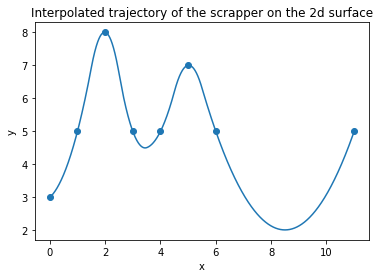

In [20]:
X=[0,1,2,3,4,5,6,11]
Y=[3,5,8,5,5,7,5,5]
global pos
pos = compute_trajectory_from_positions(X,Y,10**6,0.00001,2)


## Pre-Computing a surface

(300, 300)


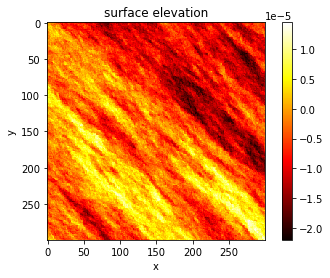

highest elevation: 1.4475535638988492e-05


In [21]:
k=1000                      #String constant for impact sound on solid materials
max_intensity = 200_558_555_0


global surface
surface = create_surface(standard_elevation = 10**-6, mode = "random_walk")


In [22]:
w1 = np.ones(10)
b1=np.ones(10)
a1=np.ones(10)

for i in range(len(w1)):
    w1[i] = random.uniform(20,10000)
    b1[i] = random.uniform(0,1000)
    a1[i] = random.uniform(0,10)

w2 = np.ones(10)
b2=np.ones(10)
a2=np.ones(10)

for i in range(len(w2)):
    w2[i] = random.uniform(20,10000)
    b2[i] = random.uniform(0,1000)
    a2[i] = random.uniform(0,10)

    

print('\n a:',a1,'\n b:',b1,'\n w:',w1)





 a: [4.35524755 7.64196019 6.15764045 8.00751442 3.50997312 6.0638843
 9.44238202 7.73197334 5.78684245 8.639864  ] 
 b: [ 87.97421869 999.13827285 434.15263182 145.426115   694.35619723
 712.73222125 192.99479792 915.26874699  74.07099465  10.96251432] 
 w: [9050.87146303 8799.37539963 2841.19166269 8314.51123306 8042.57016357
  983.63744884 6402.27267564 5167.82365768 3859.08580213 8915.08766278]


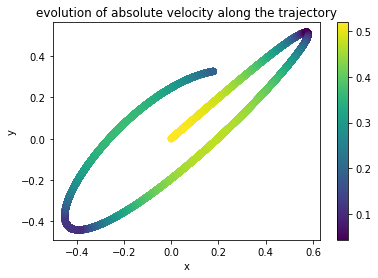

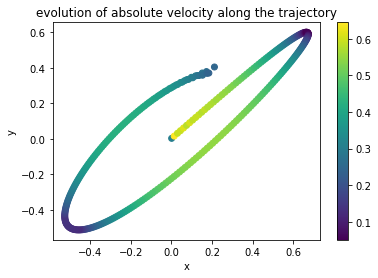

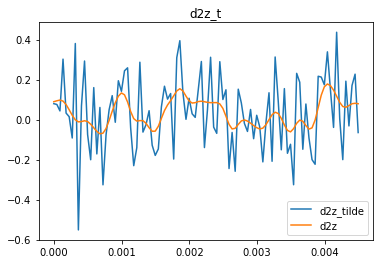

vertical: [ 0.00891949  0.00938323  0.00974187 ... -0.00092651 -0.00061367
 -0.00047848]
horizontal: [0.01835705 0.01835704 0.01835704 ... 0.00822684 0.00822615 0.00822547]

 max power of signal:  -14.089687818990601


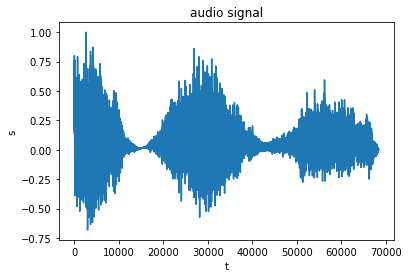

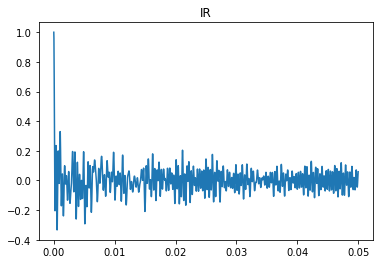

In [23]:
m=0.1
T=3.0
horizontal_mode=1
linear_param = 'x'
f,H,sr,Hsurf=generate_scraping(surface,'bio',T,a1,b1,w1,a2,b2,w2,m,horizontal_mode,linear_param)
H = librosa.util.normalize(H)
s=np.convolve(f,H,'full')
print('\n max power of signal: ', 20 * np.log10(np.max(np.abs(s))))
#s=s/max_intensity              
s=librosa.util.normalize(s)
plt.title("audio signal")
plt.plot(range(len(s)),s)
plt.xlabel('t')
plt.ylabel('s')
plt.show()

audio_signal(s,sr,"scraping.wav")

plt.title("IR")
plt.plot(np.linspace(0,0.05,len(H)),H)


IPython.display.Audio("scraping.wav")


In [29]:

print(librosa.resample(np.array([1.0,2.0,3.0,4.0,5.0,6.0]),orig_sr=2,target_sr = 1))

[0.99468887 2.86530007 5.387525  ]


In [ ]:
IRduration = 0.1
N = int (sr * IRduration)

yf = fft(Hsurf)
xf = fftfreq(N, 1 / sr)
plt.xlabel('freq')
plt.ylabel('IR amplitude')
plt.plot(xf, np.abs(yf))
plt.show()

print('\n max power of signal: ', 20 * np.log10(np.max(np.abs(Hsurf))) ,'dB')

Hsurf=librosa.util.normalize(Hsurf)
audio_signal(Hsurf,sr,"IR.wav")
IPython.display.Audio("IR.wav")

## Automated Data Generation

In [36]:
for i in range(1,100):
    for j in range(1,100):
        for p in range(1,100):
            for q in range(1,100):
                if ((i/j)**3 + (p/q)**3) == 6.0:
                    print(i,j,p,q)

17 21 37 21
17 21 74 42
34 42 37 21
34 42 74 42
37 21 17 21
37 21 34 42
37 21 51 63
37 21 68 84
51 63 37 21
51 63 74 42
68 84 37 21
68 84 74 42
74 42 17 21
74 42 34 42
74 42 51 63
74 42 68 84


# Scraping sound generation process

## Drawing the motion of scraper on the surface  

In [ ]:
from math import pi
from ipycanvas import Canvas

canvas = Canvas(width=300, height=200, layout=dict(width="100%"))

def reset_canvas():
    canvas.fill_style = "black"
    canvas.fill_rect(0, 0, canvas.width, canvas.height)
    canvas.fill_style = "white"
    canvas.fill_rect(1, 1, canvas.width-2, canvas.height-2)

from ipywidgets import Output
print ("Controls : crtl = start drawing the motion \n           shift = reset drawing \n           s = save motion (what you may draw after is irrelevent)")
out = Output()
reset_canvas()

tmp_pos=[]
positions=[]
w=True

@out.capture()
def on_keyboard_event(key, shift_key, ctrl_key, meta_key):
    if ctrl_key:
        canvas.on_mouse_move(handle_mouse_move)
        
        
    if shift_key:
        tmp_pos=[]
        reset_canvas()
        
        
    if key=="s":
        positions=tmp_pos
        
        
def handle_mouse_move(x, y):
    if w:
        canvas.fill_style = "black"
        canvas.fill_rect(x, y, 1, 1)
        positions.append((x,y))
        tmp_pos.append((x,y))
        
canvas.on_key_down(on_keyboard_event)

canvas


## Adjust latent variables

In [ ]:
mass_widget = widgets.FloatSlider(value=0.5,min=0,max=1.0,step=0.001,description='mass:',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f',)
display(mass_widget)
duration_widget = widgets.FloatSlider(value=3,min=0,max=10.0,step=0.1,description='duration:',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f',)
display(duration_widget)

N=10
a_widgets=[]
b_widgets=[]
w_widgets=[]
for i in range (N):
    a_widgets.append(widgets.FloatLogSlider(value=1,base=10,min=-5,max=3,step=0.2,description='a'+str(i+1)))
    display(a_widgets[i])
for i in range (N):
    b_widgets.append(widgets.FloatLogSlider(value=800,base=10,min=-5,max=5,step=0.2,description='b'+str(i+1)))
    display(b_widgets[i])
for i in range (N):
    w_widgets.append(widgets.FloatSlider(value=200,base=10,min=0,max=20000,step=0.2,description='w'+str(i+1)))
    display(w_widgets[i])

